In [1]:
from __future__ import print_function

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
import numpy as np

In [50]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = 'opusparcus_v2/en-train-100K.txt'

In [3]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

In [4]:
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

In [5]:
lines[0].split('\t')

['en-N7',
 'Jumby now wants to be born .',
 'Jumby want birth .',
 '77.5163',
 '2.5',
 '5',
 '9']

In [6]:
for line in lines[: min(num_samples, len(lines) - 1)]:
    _, input_text, target_text, _, _, _, _ = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

In [7]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [8]:
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 10000
Number of unique input tokens: 81
Number of unique output tokens: 102
Max sequence length for inputs: 121
Max sequence length for outputs: 126


In [9]:
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

In [10]:
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

In [11]:
encoder_input_data.shape

(10000, 121, 81)

In [12]:
decoder_input_data.shape

(10000, 126, 102)

In [13]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
    decoder_input_data[i, t + 1:, target_token_index[' ']] = 1.
    decoder_target_data[i, t:, target_token_index[' ']] = 1.

In [14]:
num_encoder_tokens

81

In [15]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [16]:
encoder_inputs.shape

TensorShape([Dimension(None), Dimension(None), Dimension(81)])

In [30]:
state_h.shape

TensorShape([Dimension(None), Dimension(256)])

In [17]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)

In [18]:
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [19]:
decoder_inputs.shape

TensorShape([Dimension(None), Dimension(None), Dimension(102)])

In [20]:
decoder_outputs.shape

TensorShape([Dimension(None), Dimension(None), Dimension(102)])

In [21]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [28]:
from tensorflow import keras
from tensorflow.keras.utils import plot_model

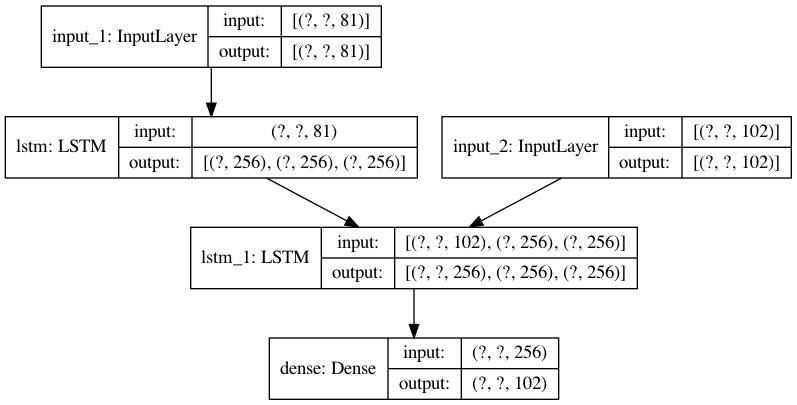

In [29]:
plot_model(model, show_shapes=True)

In [51]:
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
# Save model
model.save('s2s.h5')

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 [==============================] - 106s 13ms/sample - loss: 0.2783 - acc: 0.9194 - val_loss: 0.2682 - val_acc: 0.9213
Epoch 2/100
8000/8000 [==============================] - 112s 14ms/sample - loss: 0.2667 - acc: 0.9226 - val_loss: 0.2601 - val_acc: 0.9248
Epoch 3/100
8000/8000 [==============================] - 118s 15ms/sample - loss: 0.2562 - acc: 0.9256 - val_loss: 0.2530 - val_acc: 0.9254
Epoch 4/100
8000/8000 [==============================] - 101s 13ms/sample - loss: 0.2634 - acc: 0.9254 - val_loss: 0.2448 - val_acc: 0.9289
Epoch 5/100
8000/8000 [==============================] - 109s 14ms/sample - loss: 0.2396 - acc: 0.9306 - val_loss: 0.2379 - val_acc: 0.9312
Epoch 6/100
8000/8000 [==============================] - 113s 14ms/sample - loss: 0.2310 - acc: 0.9333 - val_loss: 0.2295 - val_acc: 0.9332
Epoch 7/100
8000/8000 [==============================] - 116s 15ms/sample - loss: 0.2237 - acc: 0.9350 - val_los

Epoch 59/100
8000/8000 [==============================] - 95s 12ms/sample - loss: 0.0778 - acc: 0.9765 - val_loss: 0.2022 - val_acc: 0.9511
Epoch 60/100
8000/8000 [==============================] - 95s 12ms/sample - loss: 0.0770 - acc: 0.9767 - val_loss: 0.2031 - val_acc: 0.9514
Epoch 61/100
8000/8000 [==============================] - 95s 12ms/sample - loss: 0.0761 - acc: 0.9769 - val_loss: 0.2031 - val_acc: 0.9514
Epoch 62/100
8000/8000 [==============================] - 95s 12ms/sample - loss: 0.0750 - acc: 0.9773 - val_loss: 0.2061 - val_acc: 0.9511
Epoch 63/100
8000/8000 [==============================] - 95s 12ms/sample - loss: 0.0744 - acc: 0.9775 - val_loss: 0.2049 - val_acc: 0.9513
Epoch 64/100
8000/8000 [==============================] - 95s 12ms/sample - loss: 0.0739 - acc: 0.9775 - val_loss: 0.2058 - val_acc: 0.9513
Epoch 65/100
8000/8000 [==============================] - 95s 12ms/sample - loss: 0.0726 - acc: 0.9780 - val_loss: 0.2079 - val_acc: 0.9515
Epoch 66/100
8000/80

In [52]:
# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [53]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

In [54]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [55]:
si = 50

In [56]:
# Take one sequence (part of the training set)
# for trying out decoding.
input_seq = encoder_input_data[si: si + 1]
decoded_sentence = decode_sequence(input_seq)
print('-')
print('Input sentence:', input_texts[si])
print('Decoded sentence:', decoded_sentence)

-
Input sentence: Didn 't you get my message ?
Decoded sentence: You didn 't see that ?



In [57]:
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: Jumby now wants to be born .
Decoded sentence: Is everything ready ?

-
Input sentence: It was a difficult and long delivery .
Decoded sentence: That was there as aboutide it .

-
Input sentence: I like to be beautiful everyday .
Decoded sentence: I would rather die .

-
Input sentence: Bernadette wants a prenup .
Decoded sentence: Put your seatbelt on .

-
Input sentence: Don 't say you don 't remember me .
Decoded sentence: Don 't look at me like that .

-
Input sentence: Hyah ! Hmm .
Decoded sentence: My father 's gone .

-
Input sentence: He believes in you .
Decoded sentence: He won 't be coming back .

-
Input sentence: Sun 's going to come up soon .
Decoded sentence: That 's a felon .

-
Input sentence: Mars-1 , Houston .
Decoded sentence: The poor guy .

-
Input sentence: But we have no money .
Decoded sentence: What about the children ?

-
Input sentence: Do you want to go first ?
Decoded sentence: You want some help ?

-
Input sentence: I 'm not singing .
De

-
Input sentence: A drop of dew and the clock struck two .
Decoded sentence: And what happened then ?

-
Input sentence: We have evidence .
Decoded sentence: We have to get outta here .

-
Input sentence: He 's in critical condition .
Decoded sentence: He won 't be back .

